<a href="https://colab.research.google.com/github/georgezefko/Anomaly-Detection-for-Sequential-Data/blob/branch_updates/AML_VAE_NO_REnc_Green_mobility_26_04_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip3 install pickle5

     |████████████████████████████████| 133kB 5.5MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219251 sha256=64438a74b25841b81d7fb17a8fdb1933277bc5bc235176600dfa2216a697982e
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [3]:
import numpy as np
import torch
from torch import nn, optim
from torch import distributions
from torch.utils.data import DataLoader, TensorDataset

from torch.autograd import Variable
import os
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
from torch.nn.parameter import Parameter
import math
from torch.nn import functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import pickle5 as pickle

In [4]:

#Green mobility data
#path = '/content/drive/MyDrive/AdvancedML/data/aligned_GM-5683_DRD-e9efaba7-a322-4793-a019-9592fb3ee73f_IRI.pickle' #original
path = '/content/drive/MyDrive/AdvancedML/data/resampled_df.pickle' #resample
with open(path, "rb") as fh:
  data = pickle.load(fh)



#Heartbeat data - getting good results
# data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TRAIN', delimiter=',')
# data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TEST', delimiter=',')[:-1]

#Gun motion data- very bad results could be due to low amount of data
# data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/GunPointAgeSpan/GunPointAgeSpan_TRAIN.txt')
# data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/GunPointAgeSpan/GunPointAgeSpan_TEST.txt')

#Modestrain data- quite good results
# data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/MoteStrain/MoteStrain_TRAIN.txt')
# data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/MoteStrain/MoteStrain_TEST.txt')

In [5]:
data

,GM.obd.spd_veh.value_resampled,GM.acc.xyz.z_resampled,IRI_mean
0,"[86.16, 86.16212875339731, 86.17, 86.23, 86.22...","[1.0, 1.0, 1.0, 0.98, 0.95, 0.94, 0.98, 0.9713...",1.51418
1,"[86.32000000000001, 86.27, 86.24345191303775, ...","[1.0, 1.0, 1.0, 1.02, 1.0338803450418523, 1.05...",1.38723
2,"[86.23, 86.1967662154625, 86.05, 86.0618858267...","[0.94, 0.88, 0.88, 0.93, 0.93, 1.0087704273372...",1.49057
3,"[86.27, 86.27, 86.28075666217394, 86.38, 86.37...","[1.0, 0.93, 0.95, 0.99, 0.9870294563438623, 0....",1.58045
4,"[86.36, 86.31, 86.30259683296475, 86.27, 86.32...","[0.98, 0.96, 0.98, 0.98, 0.97, 0.9536732891567...",1.57347
...,...,...,...
5026,"[80.18, 80.18708565614735, 80.2, 80.1807878920...","[0.99, 0.987953789453821, 0.9728568839903687, ...",1.93792
5027,"[80.13, 80.15419725534622, 80.16, 80.22, 80.20...","[0.96, 0.9676620942909802, 0.9740279573115267,...",1.89542
5028,"[80.04, 80.05463541614297, 80.07006515918876, ...","[0.9, 0.9003198146564586, 0.9027985699823563, ...",1.73519
5029,"[80.09, 80.0778162710767, 80.07407561874355, 8...","[0.95, 0.9504846621084531, 0.9575837038544855,...",1.37274


In [6]:
train_data = data[['GM.acc.xyz.z_resampled','IRI_mean']]
train_data_unstack = train_data.iloc[:,0].apply(list).apply(pd.Series)
frames = pd.concat([train_data,train_data_unstack],axis=1)
frames = frames.drop(labels = 'GM.acc.xyz.z_resampled', axis=1)

In [7]:
frames

,IRI_mean,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368
0,1.51418,1.00,1.000000,1.000000,0.980000,0.950000,0.940000,0.980000,0.971371,0.960000,0.958496,0.931354,0.920000,0.910000,1.000000,0.920000,0.910000,0.950000,0.945014,0.940000,0.970000,0.970000,0.930000,0.920000,0.920000,0.970000,0.940000,0.950000,0.956678,0.980000,0.981531,1.000000,1.000000,1.000000,1.000672,1.010000,1.000738,1.000000,1.000000,1.000000,...,0.950000,0.940000,0.930000,0.930000,0.920000,0.910000,0.910000,0.890000,0.940000,0.960000,0.950000,0.958098,0.960000,0.970000,1.000000,0.983928,0.980000,0.990000,0.995552,1.040000,1.050000,1.050000,0.840000,0.960000,1.014819,1.100000,1.010000,0.954922,0.91000,0.910000,0.910000,0.980000,1.000000,0.959389,0.947035,0.917743,0.910000,0.898345,0.880000,0.86
1,1.38723,1.00,1.000000,1.000000,1.020000,1.033880,1.050000,1.040000,1.020000,1.090000,1.090000,1.090000,1.087617,1.070000,1.000000,1.090000,1.090000,1.020000,0.840000,0.839704,0.820000,0.950000,0.950000,0.950000,0.840000,0.840000,0.730000,0.730000,0.730000,0.787184,0.800000,0.800000,0.800000,0.860000,0.740000,0.850000,0.852515,0.910000,0.940000,0.938403,...,0.919613,0.980000,0.994807,1.000000,0.949393,0.910000,0.880000,0.860000,0.930000,0.950000,0.955205,0.960000,0.920000,0.950000,0.960000,0.900000,0.891890,0.890000,0.890000,0.910000,0.980000,0.932662,0.930000,0.920000,0.950000,0.950000,0.970000,0.978764,1.00000,1.000000,0.965926,0.950000,0.930000,0.930000,0.930000,0.940000,0.940000,0.960000,1.020000,1.02
2,1.49057,0.94,0.880000,0.880000,0.930000,0.930000,1.008770,1.020000,1.020000,1.020000,1.030000,1.030000,0.970000,0.970000,0.950000,0.950000,1.030000,1.030000,1.050000,0.980000,0.980000,0.980000,1.070000,1.051604,1.033881,1.020000,1.020000,0.970000,0.970000,0.970000,0.970000,1.020000,0.990000,0.960955,0.960000,0.960000,0.990000,0.990000,0.990000,0.990000,...,0.983465,1.000000,1.000000,0.950000,0.930000,0.930000,0.940000,0.940000,0.960000,1.020000,1.020000,1.020000,1.030000,1.030000,1.030000,0.990000,0.900000,0.950000,0.960000,0.900000,0.900000,0.910000,0.910000,0.960000,0.943403,0.930000,0.940000,0.910000,0.95000,0.960000,0.940000,0.890000,0.950000,0.930000,0.890000,0.930000,0.930000,0.930000,0.950000,0.93
3,1.58045,1.00,0.930000,0.950000,0.990000,0.987029,0.970000,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.940000,0.910000,0.950000,0.950000,0.930000,0.930000,0.960000,0.955925,0.930000,0.960000,0.980000,0.960000,0.980000,0.980000,0.980000,0.974084,0.970000,0.930000,0.960000,0.980000,0.949853,0.930000,0.940000,0.930000,0.930000,0.945669,0.950000,...,0.930000,0.950000,0.950000,0.972631,0.980000,0.960000,0.960000,0.960000,0.950000,1.000000,0.980000,0.934372,0.930000,0.930610,0.970000,0.990000,0.980000,0.965509,0.940000,0.940000,0.950000,0.960000,0.950000,0.930000,0.932252,0.935448,0.949327,0.970000,1.00000,0.976874,0.973458,0.970000,0.960000,0.980000,0.970000,0.970000,0.970000,0.980000,0.972523,0.96
4,1.57347,0.98,0.960000,0.980000,0.980000,0.970000,0.953673,0.930000,0.960000,0.972596,0.980000,0.930000,0.934801,0.937639,0.940000,0.930000,0.930000,0.946195,0.948151,0.950000,0.950000,0.951297,0.970000,0.960000,0.960000,0.980000,0.960000,0.940000,0.940000,0.970000,0.967346,0.960000,0.960000,0.960000,0.960000,0.930000,0.930000,0.931222,0.935907,0.947930,...,0.980000,0.960000,0.950000,0.940000,0.940000,0.940000,0.990000,0.911932,0.910000,0.940000,0.960000,0.960000,0.940000,0.940000,0.940000,0.940000,0.950000,0.960000,0.960000,0.951390,0.940000,0.950000,0.950000,0.940000,0.933261,0.930000,0.948239,0.950000,0.95000,0.950000,0.957999,0.960000,0.951391,0.940000,0.949118,0.954997,0.960000,0.970000,0.975592,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [8]:
Normal = frames.loc[(frames['IRI_mean'] < 2)].drop(labels='IRI_mean', axis=1).reset_index(drop=True)
Anomaly = frames.loc[(frames['IRI_mean'] >2)].drop(labels='IRI_mean', axis=1).reset_index(drop=True)

In [12]:
RANDOM_SEED = 42
train_df, val_df = train_test_split(Normal,test_size=0.33,random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df,test_size=0.15, random_state=RANDOM_SEED)


#anomaly



In [13]:
scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
test_df = scaler.transform(test_df)
val_df = scaler.transform(val_df)
anomaly_df = scaler.fit_transform(Anomaly)


In [14]:

train_df = np.expand_dims(train_df,-1)
test_df = np.expand_dims(test_df,-1)
val_df = np.expand_dims(val_df,-1)
anomaly_df = np.expand_dims(anomaly_df,-1)

In [ ]:
train_df.shape

(3252, 369, 1)

In [ ]:
anomaly_df.shape

(176, 369, 1)

In [15]:
train_dataset = TensorDataset(torch.from_numpy(train_df).float())
test_dataset = TensorDataset(torch.from_numpy(test_df).float())
val_dataset = TensorDataset(torch.from_numpy(val_df).float())
anomaly_dataset = TensorDataset(torch.from_numpy(anomaly_df).float())

In [16]:
seq_len = train_df.shape[1]
n_features = train_df.shape[2]

In [ ]:
seq_len

369

In [17]:
cuda = torch.cuda.is_available()

In [18]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, pin_memory=cuda, drop_last=True)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for i in test_loader:
  print(i[0].shape)

torch.Size([64, 369, 1])
torch.Size([64, 369, 1])
torch.Size([64, 369, 1])


In [20]:
class Encoder(nn.Module):

  def __init__(self, n_features, hidden_size, hidden_layer_depth, latent_length, bidirectional,dropout):

    super(Encoder,self).__init__()


    self.n_features = n_features
    self.hidden_size = hidden_size
    self.hidden_layer_depth = hidden_layer_depth
    self.latent_length = latent_length
    self.bidirectional = bidirectional
    self.direction_factor = (2 if self.bidirectional else 1)
    


    self.rnn1 = nn.GRU( input_size=self.n_features, 
                       hidden_size=self.hidden_size, 
                       dropout = dropout, 
                       num_layers = self.hidden_layer_depth,
                       batch_first=True,bidirectional = self.bidirectional)
      
  def forward(self, x):
    
    x = x.to(device)
    #print('input',x.shape)
    batch = x.size(0)
    h0 = torch.zeros(hidden_layer_depth*self.direction_factor, batch, self.hidden_size).to(device)

    out,hidden_n = self.rnn1(x,h0) 
    #print('hidden',hidden_n.shape)
    if self.bidirectional:

      last_hidden_state = hidden_n.view(hidden_layer_depth, self.direction_factor, batch, self.hidden_size)[-1] #(num_directions, batch, hidden_size)
      #print('final',last_hidden_state.shape)
      h_1, h_2 = last_hidden_state[0], last_hidden_state[1]
      #print('h1',h_1.shape)
      #print('h2',h_2.shape)

      #X = h_1 + h_2                # Add both states (needs different input size for first linear layer)
      hidden = torch.cat((h_1, h_2), 1)  # Concatenate both states
      #print('X',hidden.shape)
    else:
      hidden = hidden_n[-1, :, :]
      #print('cell',hidden.shape)
    

    return hidden



In [ ]:
# hidden_size = 90
# hidden_layer_depth = 1
# latent_length = 20
# bidirectional = False

# # encoder
# en = Encoder(n_features, hidden_size, hidden_layer_depth, hidden_size, bidirectional, dropout).to(device)
# en


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Encoder(
  (rnn1): GRU(1, 90, batch_first=True, dropout=0.2)
)

In [ ]:
# X= next(iter(train_loader))
# x = X[0].to(device)
# outputs = en(x.float())
# cell = outputs

In [ ]:
# print('cell',cell.shape)


cell torch.Size([32, 90])


In [21]:
class Latent(nn.Module):
    """Lambda module converts output of encoder to latent vector
    :param hidden_size: hidden size of the encoder
    :param latent_length: latent vector length
    """
    def __init__(self, hidden_size, latent_length,bidirectional):
        super(Latent, self).__init__()

        self.bidirectional = bidirectional
        self.direction_factor = (2 if self.bidirectional else 1)
        self.hidden_size = hidden_size
        self.latent_length = latent_length

        self.hidden_to_mean = nn.Linear(self.hidden_size*self.direction_factor, self.latent_length)
        self.hidden_to_logvar = nn.Linear(self.hidden_size*self.direction_factor, self.latent_length)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)

    def forward(self, cell_output):
        
        self.latent_mean = self.hidden_to_mean(cell_output)
        self.latent_logvar = self.hidden_to_logvar(cell_output)
        z_mu = self.latent_mean
        z_var = self.latent_logvar
        

        
        std = torch.exp(0.5 * self.latent_logvar)
        eps = torch.randn_like(std)
        sample = eps.mul(std).add_(self.latent_mean)

        return sample, z_mu, z_var
        

In [ ]:
# #latent
# latent_length=20
# bidirectional = False
# la = Latent(hidden_size,latent_length,bidirectional).to(device)

In [ ]:
# sample,z_mu,z_var = la(cell)

In [ ]:
# print(sample.shape)
# print(z_mu.shape)
# print(z_var.shape)

torch.Size([32, 20])
torch.Size([32, 20])
torch.Size([32, 20])


In [22]:

class Decoder(nn.Module):

  def __init__(self, seq_len, batch_size, hidden_size, hidden_layer_depth, latent_length, n_features,bidirectional):
    super(Decoder, self).__init__()

    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.hidden_layer_depth = hidden_layer_depth
    self.latent_length = latent_length
    self.n_features = n_features
    self.bidirectional = bidirectional
    self.direction_factor = (2 if self.bidirectional else 1)
    
    

    self.rnn1 = nn.GRU(input_size=1,
                       hidden_size=self.hidden_size,
                       dropout = dropout,
                       num_layers=hidden_layer_depth,
                       batch_first=True,
                       bidirectional= bidirectional
                       )

    

    self.latent_to_hidden = nn.Linear(self.latent_length,self.hidden_size)
    self.hidden_to_output = nn.Linear(self.hidden_size*self.direction_factor, self.n_features)

    self.decoder_inputs = torch.zeros( self.batch_size, self.seq_len, 1, requires_grad=True).to(device)

    nn.init.xavier_uniform_(self.latent_to_hidden.weight)
    nn.init.xavier_uniform_(self.hidden_to_output.weight)


  def forward(self, x):
    #print('original',x.shape)
    x = x.to(device)
    h_state = self.latent_to_hidden(x)
    #print('h_state',h_state.shape)


    h_0 = torch.stack([h_state for _ in range(self.hidden_layer_depth*self.direction_factor)]).to(device)
    #print('h0',h_0.shape)

    
    d = self.decoder_inputs
    #print('input',d.shape)
    decoder_output, _ = self.rnn1(self.decoder_inputs, h_0)
    #print('decoder_output',decoder_output.shape)

    out = self.hidden_to_output(decoder_output)

    return out

In [23]:
class VAE(nn.Module):

  def __init__(self, enc,lat,dec):

    super(VAE,self).__init__()

  
    self.enc = enc
    self.lat = lat
    self.dec = dec
    

  def forward(self, x):

    encoder_output = self.enc(x)
    sample,z_mu,z_var = self.lat(encoder_output)
    x_hat = self.dec(sample)



    return x_hat, z_mu, z_var 

In [24]:
hidden_size = 64
hidden_layer_depth = 1
latent_length = 10
dropout = 0.5
bidirectional = True
# encoder
encoder = Encoder( n_features, hidden_size, hidden_layer_depth, latent_length,bidirectional, dropout)

#latent
latent = Latent( hidden_size, latent_length, bidirectional)

# decoder
decoder = Decoder(seq_len, batch_size, hidden_size, hidden_layer_depth, latent_length, n_features,bidirectional)

# vae
model = VAE(encoder,latent,decoder).to(device)



print(model)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


VAE(
  (enc): Encoder(
    (rnn1): GRU(1, 64, batch_first=True, dropout=0.5)
  )
  (lat): Latent(
    (hidden_to_mean): Linear(in_features=64, out_features=10, bias=True)
    (hidden_to_logvar): Linear(in_features=64, out_features=10, bias=True)
  )
  (dec): Decoder(
    (rnn1): GRU(1, 64, batch_first=True, dropout=0.5)
    (latent_to_hidden): Linear(in_features=10, out_features=64, bias=True)
    (hidden_to_output): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [25]:
def loss(X, x_hat, z_mu, z_var, beta, criterion):
  

  if criterion == 'MSELoss':
    criterion = nn.MSELoss(size_average=False,reduction='sum')
  elif criterion == 'SmoothL1Loss':
    criterion = nn.SmoothL1Loss(size_average=False,reduction='sum')

  recon_loss = criterion(x_hat, X)
  KL_loss = -0.5 * torch.mean(1 + z_var - z_mu**2 - torch.exp(z_var))
  #KL_loss/= X.shape[0] * 32
  elbo_loss = recon_loss + beta * KL_loss
  
  return elbo_loss, KL_loss

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.0001) # lr derived from optimazation method

#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [27]:
X= next(iter(train_loader))
x = X[0].to(device)
outputs = model(x.float())


x_hat, z_mu, z_var = outputs

#total_loss, elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var, x_sample, mu_rec, var_rec, z_sample,criterion='SmoothL1Loss')
print('x',x.shape)
print('mu',z_mu.shape)
print('var',z_var.shape)
print('x_hat',x_hat.shape)
# print('total',total_loss)
# print('elbo',elbo_loss)
# print('KL',KL_loss)


x torch.Size([32, 369, 1])
mu torch.Size([32, 10])
var torch.Size([32, 10])
x_hat torch.Size([32, 369, 1])


In [29]:
elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var,beta=0.5,criterion='SmoothL1Loss')

print(elbo_loss)
print(KL_loss)

tensor(4710.2061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0147, device='cuda:0', grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [30]:
def train():
 

  model.train()

  train_loss = []
  train_kl = []
  
  

  for t, X in enumerate(train_loader):

    X =X[0]
    #print('trina',X.shape)
    X = X.to(device)

    optimizer.zero_grad()

    x_hat, z_mu, z_var= model(X)

    elbo_loss, KL_loss = loss(X, x_hat, z_mu, z_var, beta = 1,criterion='MSELoss')
    # total_loss = (len(train_loader)/X.shape[0])*total_loss
    # elbo_loss = (len(train_loader)/X.shape[0])*elbo_loss

    elbo_loss.backward()

    train_loss.append(elbo_loss.item())
    train_kl.append(KL_loss.item())
    

    optimizer.step()
  
  train_elbo_loss = np.mean(train_loss)
  train_kl_loss = np.mean(train_kl)
 

  return  train_elbo_loss,train_kl_loss

In [31]:
def test():

  model.eval()

  with torch.no_grad():
    test_loss = []
    test_kl = []
    
    for t, x in enumerate(val_loader):

      x = x[0]
      x = x.to(device)
      x_hat, z_mu, z_var = model(x)
      elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var,beta=1,criterion='SmoothL1Loss')
      # total_loss = (len(val_loader)/x.shape[0])*total_loss
      # elbo_loss = (len(val_loader)/x.shape[0])*elbo_loss

      test_loss.append(elbo_loss.item())
      test_kl.append(KL_loss.item())
      

  test_elbo_loss = np.mean(test_loss)
  test_kl_loss = np.mean(test_kl)
  

  return model.eval(), test_elbo_loss,test_kl_loss

In [32]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
epochs = 100

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
history_elbo = dict(train_elbo=[], test_elbo=[])
history_kl = dict(train_kl=[], test_kl=[])


device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for e in range(epochs):

  start_time = time.time()

  train_elbo_loss, train_kl_loss = train()
  model, test_elbo_loss, test_kl_loss  = test()

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if best_loss > test_elbo_loss:
    best_test_loss = test_elbo_loss
    best_model_wts = copy.deepcopy(model.state_dict())

  print(f'Epoch: {e+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\t train elbo loss {train_elbo_loss}   | train kl loss {train_kl_loss}') 
  print(f'\t val  val elbo loss {test_elbo_loss} | valid kl loss {test_kl_loss}') 


  history_elbo['train_elbo'].append(train_elbo_loss)
  history_elbo['test_elbo'].append(test_elbo_loss)

  history_kl['train_kl'].append(train_kl_loss)
  history_kl['test_kl'].append(test_kl_loss)


Using device: cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 01 | Epoch Time: 0m 3s
	 train elbo loss 11829.90671410891   | train kl loss 0.013502884923600324
	 val  val elbo loss 4755.58074079241 | valid kl loss 0.01313347007990593
Epoch: 02 | Epoch Time: 0m 3s
	 train elbo loss 11814.432501160272   | train kl loss 0.012893450852151555
	 val  val elbo loss 4754.795375279018 | valid kl loss 0.012948170215601013
Epoch: 03 | Epoch Time: 0m 2s
	 train elbo loss 11814.294129022277   | train kl loss 0.013104213586095537
	 val  val elbo loss 4754.66791062128 | valid kl loss 0.01398605942016556
Epoch: 04 | Epoch Time: 0m 3s
	 train elbo loss 11813.695447865099   | train kl loss 0.014704347698774078
	 val  val elbo loss 4754.51105608259 | valid kl loss 0.015381909175110715
Epoch: 05 | Epoch Time: 0m 2s
	 train elbo loss 11813.396049272897   | train kl loss 0.0157354422614421
	 val  val elbo loss 4754.625860305059 | valid kl loss 0.01657378196805006
Epoch: 06 | Epoch Time: 0m 2s
	 train elbo loss 11813.369111618193   | train kl loss 0.016658573402

In [34]:
# save the model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

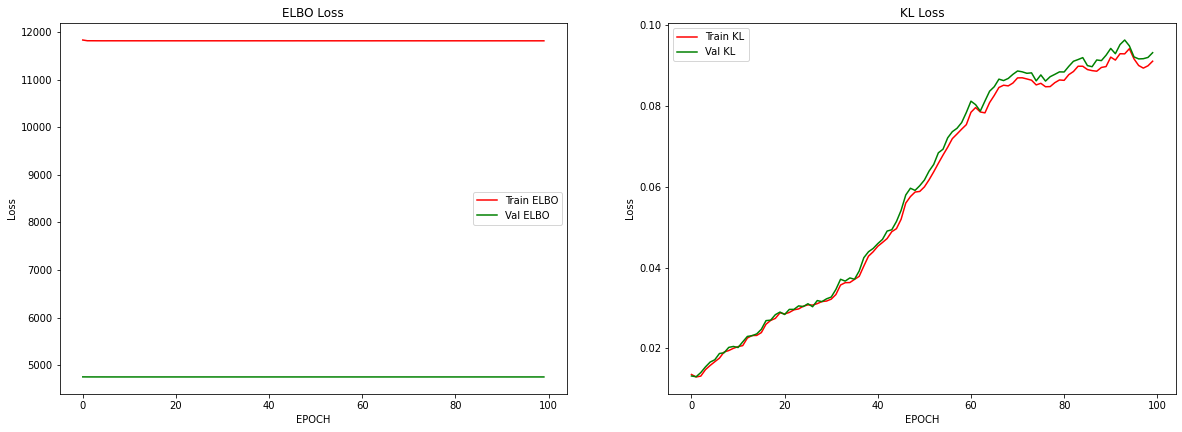

In [35]:
fig = plt.figure(figsize=(20,15))


fig.add_subplot(2,2,1)
plt.plot(list(range(0,len(history_elbo['train_elbo']))), history_elbo['train_elbo'],'r')
plt.plot(list(range(0,len(history_elbo['test_elbo']))), history_elbo['test_elbo'],'g')
plt.legend(['Train ELBO','Val ELBO'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('ELBO Loss')

fig.add_subplot(2,2, 2)
plt.plot(list(range(0,len(history_kl['train_kl']))), history_kl['train_kl'], 'r')
plt.plot(list(range(0,len(history_kl['test_kl']))), history_kl['test_kl'],'g')
plt.legend(['Train KL','Val KL'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('KL Loss')





plt.show();



In [36]:
def predict(model, dataset):
    predictions = []
    with torch.no_grad():
        model = model.eval()
    for t, X in enumerate(dataset):
        X = X[0]
        x = X.to(device)
        #x = Variable(x, requires_grad = False)
        x_hat, z_mu, z_var = model(x)
        x_hat = x_hat.cpu().detach().numpy()
        x_hat = np.squeeze(x_hat, axis=2)
        predictions.append(x_hat)
    predictions = np.concatenate(predictions, axis=0, out= None)
    return predictions

In [37]:
predict_train = predict(model, train_loader)

In [38]:
predict_train.shape

(3232, 369)

In [39]:
train_df = train_df[:3232]
train_original = np.squeeze(train_df,axis=2)

In [40]:
train_original.shape

(3232, 369)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


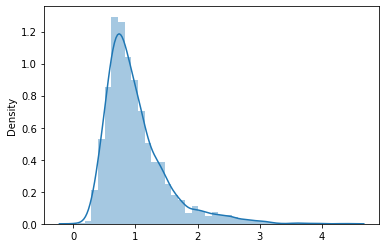

In [41]:
train_sq_loss = np.mean(( train_original- predict_train)**2, axis=1)
sns.distplot(train_sq_loss, bins=40, kde=True)
plt.show()

In [42]:
predict_test = predict(model, test_loader)
predict_test.shape

(224, 369)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


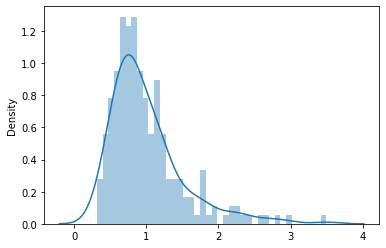

In [43]:
test_df=test_df[:224]
test_original = np.squeeze(test_df,axis=2)
test_sq_loss = np.mean(( test_original- predict_test)**2, axis=1)
sns.distplot(test_sq_loss, bins=40, kde=True)
plt.show()

In [44]:

# anomaly_dataset = TensorDataset(torch.from_numpy(anomaly_df).float())
# anomaly_loader = DataLoader(anomaly_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)
predict_anomaly = predict(model, anomaly_loader)

In [45]:
predict_anomaly.shape

(160, 369)

In [46]:
anomaly_df = anomaly_df[:160]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


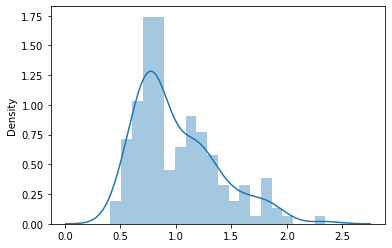

In [47]:
anomaly_sq_loss = np.mean(( np.squeeze(anomaly_df) - predict_anomaly)**2, axis=1)
sns.distplot(anomaly_sq_loss, bins=20, kde=True)
plt.show()

In [ ]:
threshold_fixed = 0.4

In [48]:
def plot_prediction(data, reconstructed, title, ax):
  ax.plot(data,'r', label='true')
  ax.plot(reconstructed, 'b',label='reconstructed')
  ax.set_title(f'{title} (Total loss: {np.around(np.mean(( data- reconstructed)**2), 2)})')
  ax.legend()

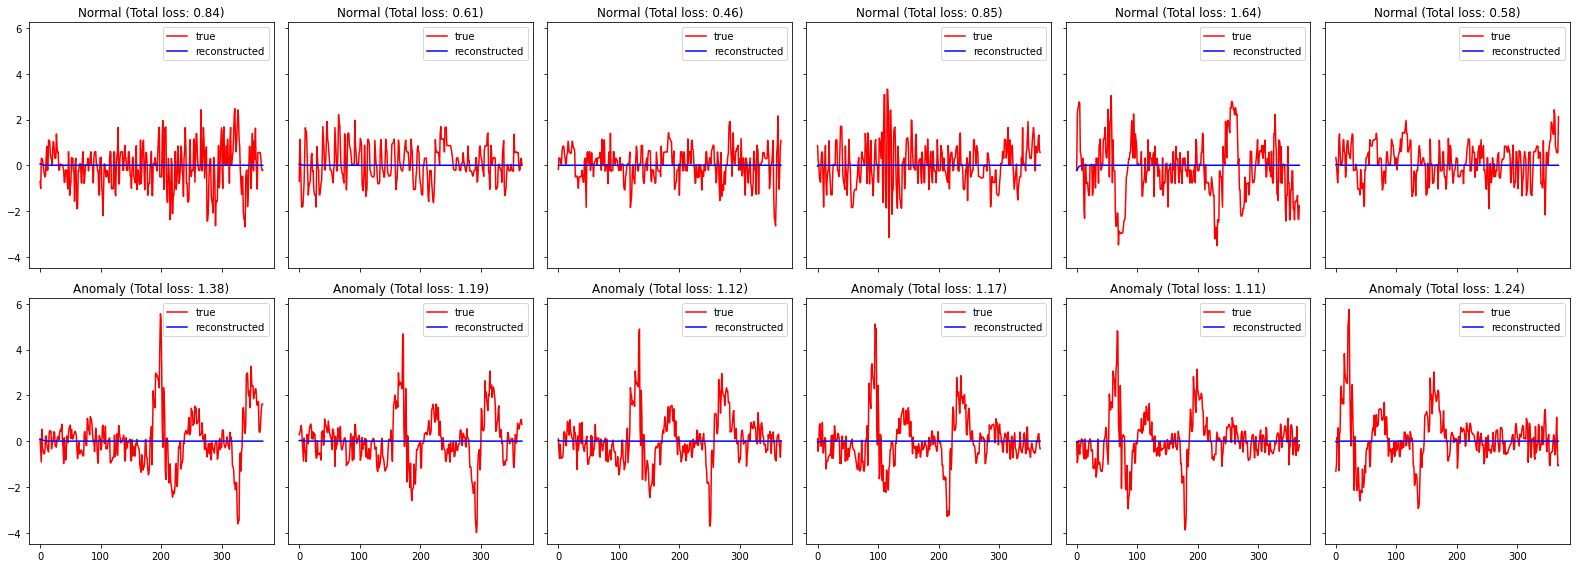

In [49]:
fig, axs = plt.subplots(nrows=2,ncols=6,sharey=True,sharex=True,figsize=(22, 8))

for i, data in enumerate(test_original[:6]):
  plot_prediction(data, predict_test[i], title='Normal', ax=axs[0, i])

for i, data in enumerate(anomaly_df[:6]):
  plot_prediction(data, predict_anomaly[i], title='Anomaly', ax=axs[1, i])

fig.tight_layout();
#plt.savefig('/content/drive/MyDrive/AdvancedML/data/green_recon.png')

In [ ]:
len(anomaly_sq_loss)

128

In [ ]:
label = np.concatenate((np.ones(len(test_sq_loss)),np.zeros(len(test_sq_loss))))
#total_losses = np.concatenate((train_sq_loss,anomaly_sq_loss),axis=0)
total_losses = np.concatenate((test_sq_loss,np.random.choice(anomaly_sq_loss, len(test_sq_loss),replace=True)),axis=0)
error_df = pd.DataFrame({'Reconstruction_error': total_losses,'Label':label})
#error_df = error_df.sample(frac=1)
error_df.head(2)

,Reconstruction_error,Label
0,0.726157,1.0
1,0.561356,1.0


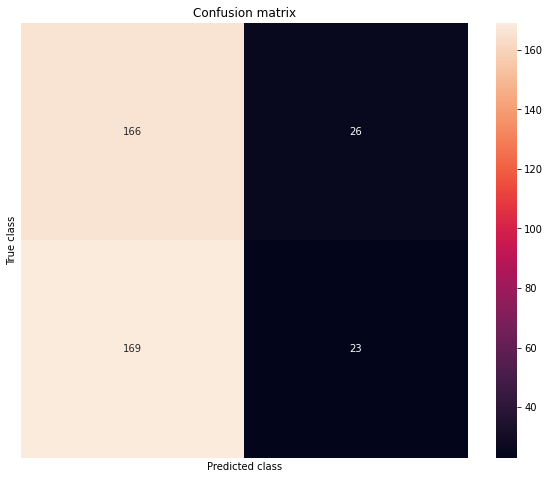

In [ ]:
pred_y = [0 if e > threshold_fixed else 1 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Label, pred_y)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=[], yticklabels=[], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
#plt.savefig('/content/drive/MyDrive/AdvancedML/data/CM_green.png')


In [ ]:
TN = conf_matrix[0][0]
FN = conf_matrix[1][0]
TP = conf_matrix[1][1]
FP = conf_matrix[0][1]

In [ ]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('Precision',precision)
print('Recall',recall)

Precision 0.38372093023255816
Recall 0.171875


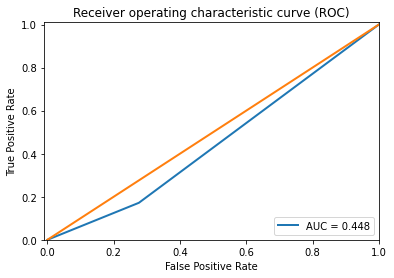

<Figure size 432x288 with 0 Axes>

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.Label, pred_y)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=2)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('/content/drive/MyDrive/AdvancedML/data/ROC_green.png')